## Time Series Forecasting: Air Passengers

In this notebook, I use data from the World Bank on air passenger numbers during 1970-2018 to forecast the air passenger numbers for 2019-2020, and compare the forecast to the passenger numbers collected by TSA for 2019-2020. This illustrates the impact of COVID-19, which, as widely reported, has caused a significant drop in the number of air passengers.

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import matplotlib.ticker as mticker
import seaborn as sns
from datetime import datetime

Reading the dataset

In [3]:
# Reading the dataset from the World Bank
dfWB = pd.read_csv('API_IS.AIR.PSGR_DS2_en_csv_v2_1678528.csv')
dfWB.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,"Air transport, passengers carried",IS.AIR.PSGR,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,223502.0,274280.00,NaN,NaN
1,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,NaN,NaN,NaN,NaN,NaN,NaN,...,2.279341e+06,1.737962e+06,2044188.0,2209428.0,1929907.0,1917924.0,1647425.0,1722612.61,NaN,NaN
2,Angola,AGO,"Air transport, passengers carried",IS.AIR.PSGR,NaN,NaN,NaN,NaN,NaN,NaN,...,9.877980e+05,1.132424e+06,1321872.0,1409952.0,1244491.0,1482546.0,1375523.0,1516628.00,NaN,NaN
3,Albania,ALB,"Air transport, passengers carried",IS.AIR.PSGR,NaN,NaN,NaN,NaN,NaN,NaN,...,8.297789e+05,8.143397e+05,865848.0,151632.0,NaN,26634.0,204090.0,303137.00,NaN,NaN
4,Andorra,AND,"Air transport, passengers carried",IS.AIR.PSGR,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Extract data for the US into a separate data frame
USap = dfWB[dfWB['Country Name']=='United States']
# Drop missing values up to 1970
USap.dropna(axis=1, inplace=True)
# Drop index
USap.set_index(['Country Name'], inplace=True)
# Select numerical values, i.e., years and passenger numbers
USap = USap.select_dtypes(include=np.number)
years = USap.columns.astype('int')
passnums = USap.values.flatten().astype('int')

# Make a data frame for the US air passengers time series
dfUS = pd.DataFrame()
dfUS['Years'] = years
dfUS['Air Passengers'] = passnums
dfUS.set_index('Years', inplace=True)
dfUS.head()


,Air Passengers
Years,
1970,163448992
1971,174143104
1972,191325408
1973,202309200
1974,207612400


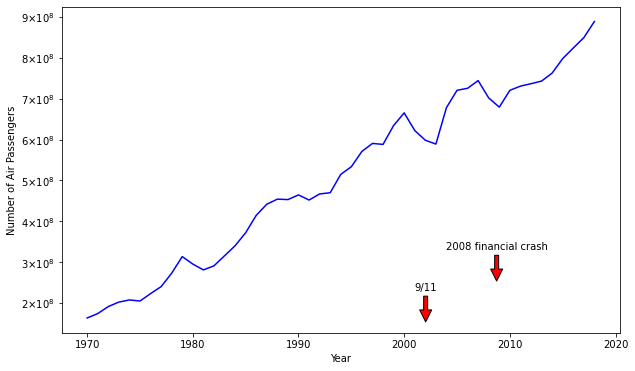

In [5]:
# Visualizing the time series dataset
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel("Year")
ax.set_ylabel("Number of Air Passengers")
ax.plot(dfUS, c='b')
y911 = 2001 + 8/12 + 11/30 # approx x-coordinate, 9/11 
y08 = 2008 + 9/12 # approx x-coordinate, 9/30/2008 financial crash
ax.annotate('9/11',
            xy=(y911, 1.5e8), xycoords='data',
            xytext=(y911, 2.5e8), textcoords='data',
            arrowprops=dict(facecolor='red', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')

ax.annotate('2008 financial crash',
            xy=(y08, 2.5e8), xycoords='data',
            xytext=(y08, 3.5e8), textcoords='data',
            arrowprops=dict(facecolor='red', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')

f = mticker.ScalarFormatter(useOffset=True, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))

There is an increasing trend over the years, with some noise. There are steep drops after 9/11 and the 2008 financial crash.

In [6]:
# Calculating the rolling mean and standard deviation for a window of 10 years
rolmean = dfUS.rolling(window=10).mean()   
rolstd = dfUS.rolling(window=10).std()     

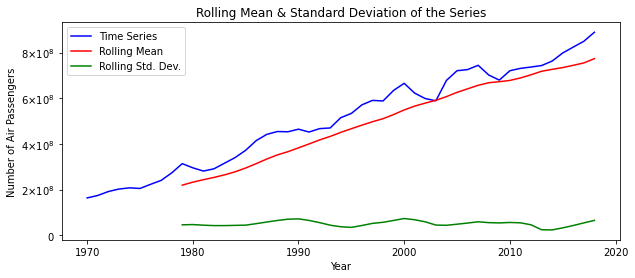

In [7]:
# Visualizing the rolling mean and standard deviation

fig, ax = plt.subplots(figsize=(10,4))
actual = ax.plot(dfUS, color='blue', label='Time Series')   
rollingmean = ax.plot(rolmean, color='red', label='Rolling Mean')   
rollingstd = ax.plot(rolstd, color='green', label='Rolling Std. Dev.')   
ax.set_title('Rolling Mean & Standard Deviation of the Series')
ax.set_xlabel('Year')
ax.set_ylabel("Number of Air Passengers")
f = mticker.ScalarFormatter(useOffset=True, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(g))

plt.legend()
plt.show()

There is a linearly increasing trend over the years, seen in the time series and the rolling mean. I will try to convert the time series to a stationary series by shifting or lagging and differencing to the lag-1 difference.

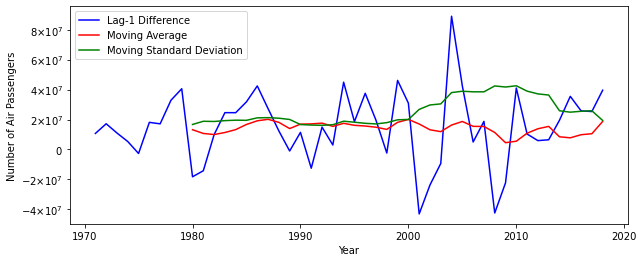

In [8]:
# Differenced series

plt.figure(figsize=(10,4))
f = mticker.ScalarFormatter(useOffset=True, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
df_shift = dfUS - dfUS.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=10).mean()   
MStd_shift = df_shift.rolling(window=10).std()   
plt.plot(df_shift, color='b', label='Lag-1 Difference')                       
plt.plot(MAvg_shift, color='red', label = 'Moving Average')  
plt.plot(MStd_shift, color='green', label = 'Moving Standard Deviation')  
plt.xlabel('Year')
plt.ylabel("Number of Air Passengers")
plt.legend()
plt.show()

# Dropping the 1 null value that we get after applying differencing
df_shift = df_shift.dropna()

The ADF test is used to test for stationarity.


In [9]:
# Define a function to use adfuller test
def adfuller(df):
  # Importing adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller
  print('Dickey-Fuller Test: ')
  adftest = adfuller(df['Air Passengers'])
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)

adfuller(df_shift)

Dickey-Fuller Test: 
Test Statistic          -4.996436
p-value                  0.000023
Lags Used                3.000000
No. of Observations     44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
dtype: float64


Since the p-value is much lower than 0.05, the null hypothesis can be rejected at the 95% confidence limits. 

However, there is visual evidence of heteroskedasticity in the time series, since we observe volatility clustering. There is a steep drop in the number of air passengers after 9/11/2001. There is also a drop in the number of passengers following the stock market crash in 2008. The ARCH or GARCH models may be better able to capture this heteroskedasticity. But here I will use an ARMA model for simplicity.

Below, I also try the log series, although the original series does not visualy look exponential. The log series is attempted to test whether it can reduce heteroskedasticity.

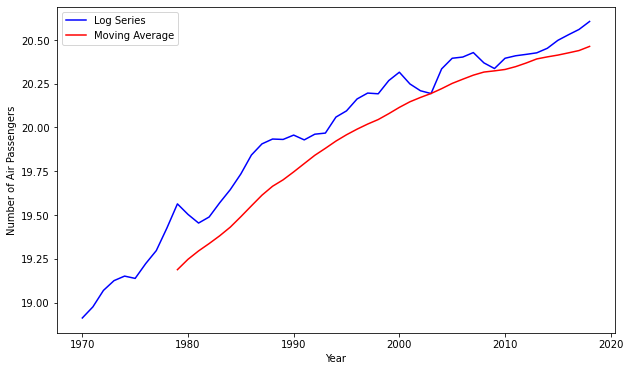

In [10]:
# Log series

plt.figure(figsize=(10,6))

df_log = np.log(dfUS)
MAvg_log = df_log.rolling(window=10).mean()   
MStd_log = df_log.rolling(window=10).std()   
plt.plot(df_log, color='b', label='Log Series')                      
plt.plot(MAvg_log, color='red', label = 'Moving Average')      
plt.xlabel('Year')
plt.ylabel("Number of Air Passengers")
plt.legend()
plt.show()

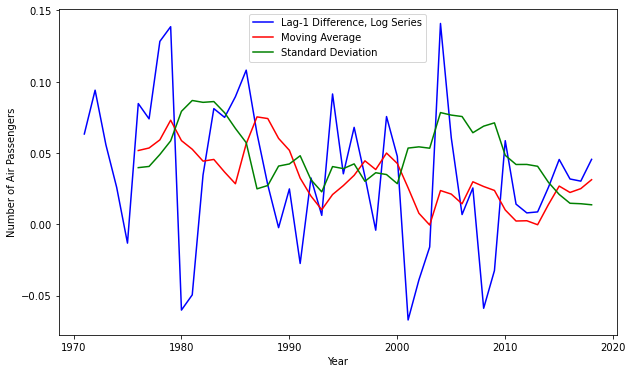

In [11]:
# Differenced log series

plt.figure(figsize=(10,6))
df_logshift = df_log - df_log.shift(periods=1)

MAvg_logshift = df_logshift.rolling(window=6).mean()   
MStd_logshift = df_logshift.rolling(window=6).std()   
plt.plot(df_logshift, color='b', label='Lag-1 Difference, Log Series')                      
plt.plot(MAvg_logshift, color='red', label = 'Moving Average')      
plt.plot(MStd_logshift, color='green', label = 'Standard Deviation')  
plt.xlabel('Year')
plt.ylabel("Number of Air Passengers")
plt.legend()
plt.show()

# Dropping the 1 null value that we get after applying differencing method
df_logshift = df_logshift.dropna()

In [12]:
adfuller(df_logshift)

Dickey-Fuller Test: 
Test Statistic          -4.932631
p-value                  0.000030
Lags Used                0.000000
No. of Observations     47.000000
Critical Value (1%)     -3.577848
Critical Value (5%)     -2.925338
Critical Value (10%)    -2.600774
dtype: float64


The ARMA model for the differenced series (df_shift) is built below.

Plotting the auto-correlation function and partial auto-correlation function to get p and q values for the ARMA model

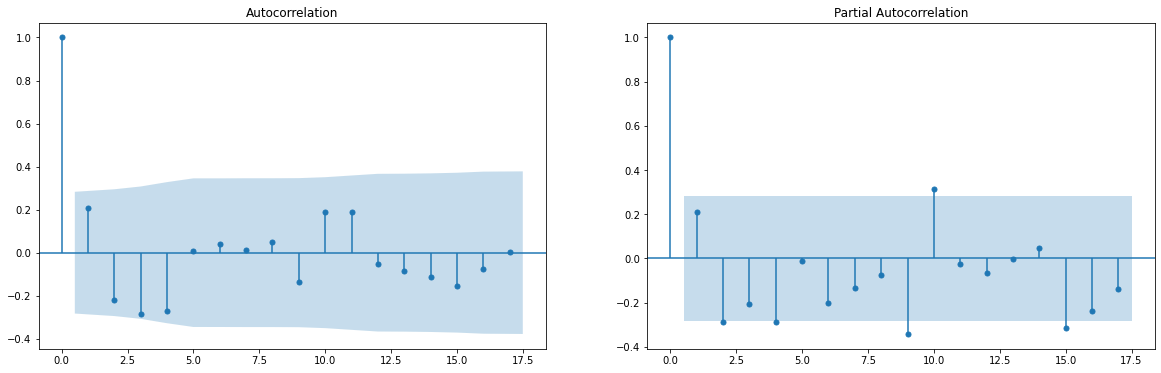

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
plot_acf(df_shift, ax=ax1)
plot_pacf(df_shift, ax=ax2)
plt.show()


The ARMA model of the differenced series (df_shift) initially with p=1, q=1 inferred from acf and pacf, is built below.

C:\Users\Aruna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


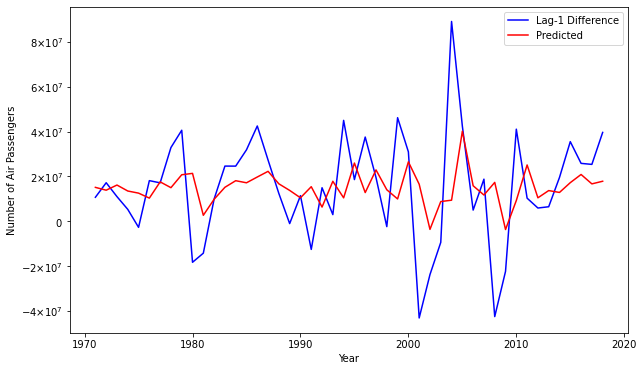

In [14]:
from statsmodels.tsa.arima_model import ARMA

#Comparing the actual & predicted series by ARMA
plt.figure(figsize=(10,6))
f = mticker.ScalarFormatter(useOffset=True, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
modelds = ARMA(df_shift, order=(0,1)) #Using p=0,q=1: MA(1), which has lower AIC and BIC than p=1,q=1
resultsds = modelds.fit()
plt.plot(df_shift, c='b', label='Lag-1 Difference')            #Visualizing the actual series used for modelling
plt.plot(resultsds.fittedvalues, color='red',label='Predicted')
plt.xlabel('Year')
plt.ylabel("Number of Air Passengers")
plt.legend()
plt.show()  

In [15]:
print(resultsds.summary())

                              ARMA Model Results                              
Dep. Variable:         Air Passengers   No. Observations:                   48
Model:                     ARMA(0, 1)   Log Likelihood                -882.086
Method:                       css-mle   S.D. of innovations       23133132.344
Date:                Wed, 02 Dec 2020   AIC                           1770.173
Time:                        01:17:44   BIC                           1775.786
Sample:                             0   HQIC                          1772.294
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.512e+07   4.37e+06      3.462      0.001    6.56e+06    2.37e+07
ma.L1.Air Passengers     0.3142      0.156      2.015      0.044       0.009       0.620
            

The ARMA model for the differenced log series is built below.

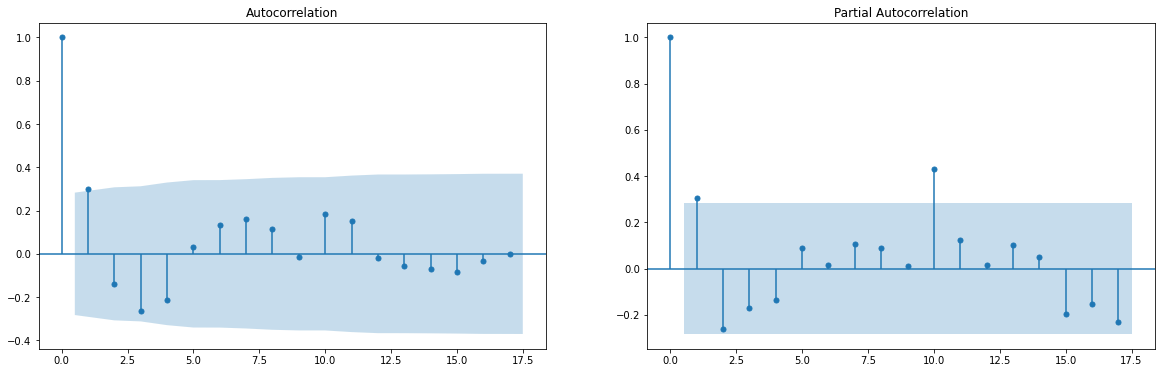

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
plot_acf(df_logshift, ax=ax1)
plot_pacf(df_logshift, ax=ax2)
plt.show()


The values p=2 and q=2 are inferred from the acf and pacf.

C:\Users\Aruna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


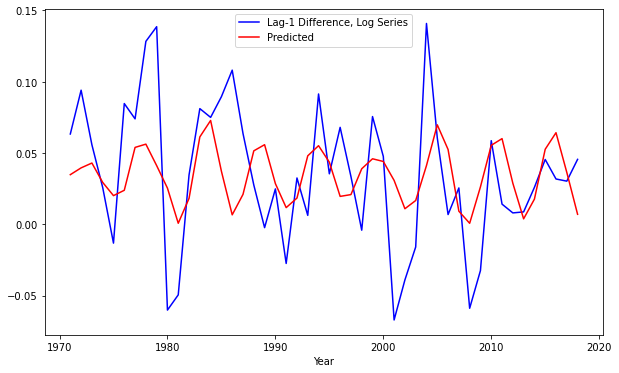

In [17]:
from statsmodels.tsa.arima_model import ARMA

#Comparing the actual & predicted series by ARMA
plt.figure(figsize=(10,6))
modeldls = ARMA(df_logshift, order=(2,2)) #using p=2, q=2
resultsdls = modeldls.fit()
plt.plot(df_logshift, c='b', label='Lag-1 Difference, Log Series')           
plt.plot(resultsdls.fittedvalues, color='red', label='Predicted')
plt.xlabel('Year')
plt.legend()
plt.show()  

In [18]:
print(resultsdls.summary())

                              ARMA Model Results                              
Dep. Variable:         Air Passengers   No. Observations:                   48
Model:                     ARMA(2, 2)   Log Likelihood                  79.891
Method:                       css-mle   S.D. of innovations              0.044
Date:                Wed, 02 Dec 2020   AIC                           -147.783
Time:                        01:17:45   BIC                           -136.556
Sample:                             0   HQIC                          -143.540
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0349      0.007      4.946      0.000       0.021       0.049
ar.L1.Air Passengers     0.7671      0.058     13.245      0.000       0.654       0.881
ar.L2.Air Pa

The log series does not improve the predictions. Below, I use the lag-1 differenced series.
Predictions based on differenced series (df_shift):

In [19]:
# Fitted values, differenced series
predds=pd.Series(resultsds.fittedvalues)

Use the inverse transformation on the predicted differenced series.

In [20]:
# Cumulative sum
predds_cumsum = predds.cumsum()    

In [21]:
# Add back first value
preddso = pd.Series(dfUS['Air Passengers'].iloc[0], index=dfUS.index)
preddso = preddso.add(predds_cumsum, fill_value=0)

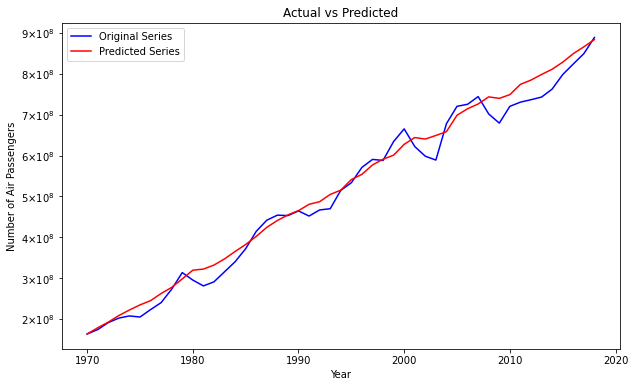

In [22]:
#Plotting the original vs predicted series
plt.figure(figsize=(10,6))
f = mticker.ScalarFormatter(useOffset=True, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.plot(dfUS, color = 'b', label = 'Original Series')
plt.plot(preddso, color = 'r', label = 'Predicted Series')      
plt.title('Actual vs Predicted')
plt.xlabel('Year')
plt.ylabel("Number of Air Passengers")
plt.legend()
plt.show()

The predicted series is much smoother than the original series. This model does not capture the variance well.

Predictions based on differenced log series(df_log_shift):

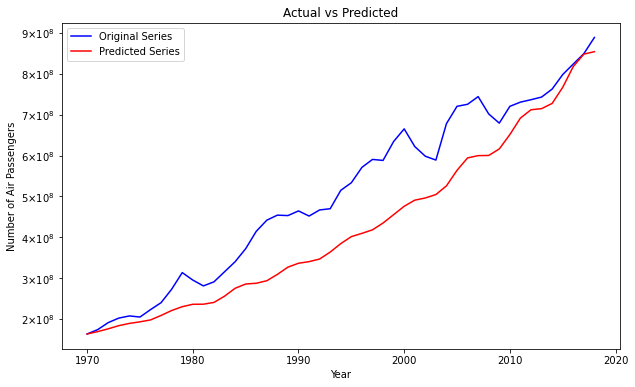

In [23]:
# Fitted values, differenced log series
preddls = pd.Series(resultsdls.fittedvalues)

# Take the inverse transformation on the predicted differenced log series.

# Cumulative sum
preddls_cumsum = preddls.cumsum()    

# Add back first value
preddlsfv = pd.Series(df_log['Air Passengers'].iloc[0], index=df_log.index)
preddlsfv = preddlsfv.add(preddls_cumsum, fill_value=0)

# Take exponential
preddlso = np.exp(preddlsfv)

#Plotting the original vs predicted series
plt.figure(figsize=(10,6))
f = mticker.ScalarFormatter(useOffset=True, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.plot(dfUS, color = 'b', label = 'Original Series')
plt.plot(preddlso, color = 'r', label = 'Predicted Series')      
plt.title('Actual vs Predicted')
plt.xlabel('Year')
plt.ylabel("Number of Air Passengers")
plt.legend()
plt.show()

The differenced log series performs worse than the differenced series. The lag-1 difference series will be used for forecasting.

### Forecasting the number of passengers for next 2 years:

The ARMA or MA model does not capture the variance in the data very well. A GARCH model may be more suited to the data, but here I use the MA(1) model based on the differenced series for simplicity.

In [24]:
# Forecasting the values for next 2 years
fcastds = resultsds.forecast(steps=2)[0]

In [25]:
# Converting the fitted values by ARMA into a list
predlist = predds.tolist()
# Converting the forecasted values by ARMA into a list
fcastdslist = fcastds.tolist()
# Combining both lists
predlist.extend(fcastdslist)

In [26]:
# Converting the combined list into a series
predseries = pd.Series(predlist, index=range(dfUS.index[0]+1, dfUS.index[0]+len(dfUS)+2))

In [27]:
# Cumulative sum
fc_cumsum = predseries.cumsum()

In [28]:
# Adding back first value
fvl = pd.Series(dfUS['Air Passengers'].iloc[0], index = range(dfUS.index[0], dfUS.index[0]+len(dfUS)+2))
fcfin = fvl.add(fc_cumsum, fill_value=0)

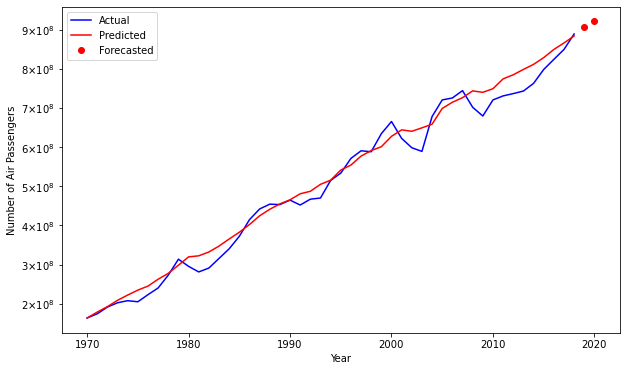

In [29]:
# Visualizing the forecasted values
plt.figure(figsize=(10,6))
f = mticker.ScalarFormatter(useOffset=True, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.plot(dfUS['Air Passengers'], label = 'Actual', color = 'b')
plt.plot(fcfin[:len(fcfin)-2], label = 'Predicted', color = 'r')  
plt.plot(fcfin[len(fcfin)-2:], 'or', label = 'Forecasted')   
plt.xlabel('Year')
plt.ylabel('Number of Air Passengers')
plt.legend()
plt.show()

In [30]:
# Read 2019 and 2020 data from TSA, data from March 1 to Nov 26 for each year

df20 = pd.read_excel('TSA_chkpt_travel_num.xlsx')
df20.columns = ['Date', '2020', '2019'] 

In [31]:
# Estimate number of passengers in 2020 and 2019

TSA20 = df20['2020'].mean()*366
TSA19 = df20['2019'].mean()*365

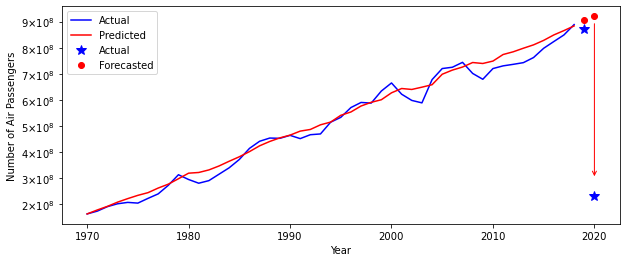

In [32]:
# Visualizing the forecasted values and estimated values

plt.figure(figsize=(10,4))
f = mticker.ScalarFormatter(useOffset=True, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.plot(dfUS['Air Passengers'], label = 'Actual', color = 'b')
plt.plot(fcfin[:len(fcfin)-2], label = 'Predicted', color = 'r')
plt.plot([2019, 2020], [TSA19, TSA20], '*b', markersize=10,label='Actual')
plt.plot(fcfin[len(fcfin)-2:], 'or', label = 'Forecasted')   
plt.gca().annotate("",
            xy=(2020, 3e8), xycoords='data',
            xytext=(2020, 9e8), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            edgecolor='r')
            )

plt.xlabel('Year')
plt.ylabel('Number of Air Passengers')
plt.legend()
plt.show()

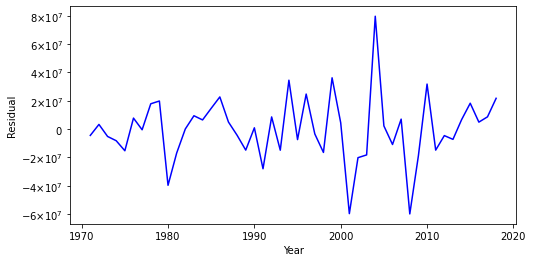

In [33]:
# Residuals from fitted values

plt.figure(figsize=(8,4))
f = mticker.ScalarFormatter(useOffset=True, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.plot(resultsds.resid, c='b')
plt.xlabel('Year')
plt.ylabel('Residual')
plt.show()

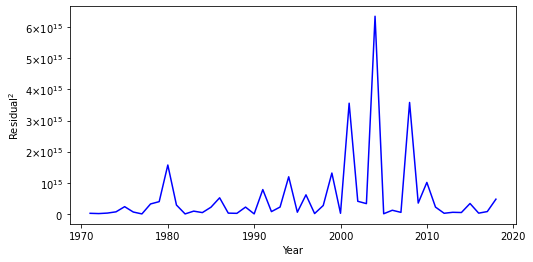

In [34]:
# Squared residuals

plt.figure(figsize=(8,4))
f = mticker.ScalarFormatter(useOffset=True, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.plot(resultsds.resid**2, c='b')
plt.xlabel('Year')
plt.ylabel('Residual$^2$')
plt.show()

Residuals suggest the GARCH model would be better suited the capture the volatility clustering.